In [1]:
import sys
sys.path.append('/home/gleech/.cache/pypoetry/virtualenvs/insurance-4BC0dsBn-py3.8/lib/python3.8/site-packages')
!pip install matplotlib

You should consider upgrading via the '/home/gleech/.cache/pypoetry/virtualenvs/insurance-4BC0dsBn-py3.8/bin/python -m pip install --upgrade pip' command.


In [2]:
import xgboost as xgb
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
df = pd.read_csv("new_train/new_train.csv")

# Can't use these for prediction
posthoc_cols = ["Claim Reason", "Customer"]
df = df.drop(posthoc_cols, axis=1)



# Check legality

In [4]:
gender_bans = ["California", "Hawaii", "Massachusetts", "Montana", "North Carolina", "Pennsylvania"]
#gender_bans_codes = ["CO", "HI", "MA", "MT", "NC", "PA"]
assert(df[df.State.isin(gender_bans)].empty)

# Onehot

In [5]:
categorical_features = ['Country', 'State Code', 'State', 'Response', 'Coverage', 'Education', 'EmploymentStatus', 'Gender', 'Location Code', \
                        'Marital Status', 'Policy Type', 'Policy', 'Sales Channel', 'Vehicle Class', 'Vehicle Size']
cat_onehots = pd.get_dummies(df[categorical_features])

df = df.join(cat_onehots) \
        .drop(categorical_features, axis=1)


# Drop bullshit columns


In [6]:
def get_constant_cols(df) :
    bs = []
    for col in df.columns :
        if len(df[col].unique()) == 1:
            bs.append(col)
    return bs


df = df.drop(get_constant_cols(df), axis=1)


print("Any low-variance cols?", any(df.std() < 0.05) )

Any low-variance cols? False


## Any time trend?

[2011]


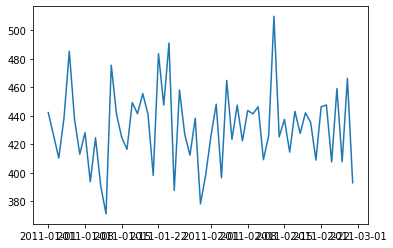

In [7]:
print(pd.to_datetime(df["Effective To Date"]).dt.year.unique())
# No annual trend then

time_trend = df[["Effective To Date","Total Claim Amount"]] \
                .groupby(pd.to_datetime(df["Effective To Date"])).mean()
plt.plot(time_trend.index, time_trend["Total Claim Amount"])
# Nothing

df = df.drop("Effective To Date", axis=1) 

# Consider fairness

In [8]:
# EmploymentStatus_Disabled!!! EmploymentStatus_Medical Leave!!!
unfair_cols = ["EmploymentStatus_Disabled", "EmploymentStatus_Medical Leave"]
# "Income" and "Education" arguably

df = df.drop(unfair_cols, axis=1)

In [9]:
y = df["Total Claim Amount"]
X = df.drop("Total Claim Amount", axis=1)


SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=SEED)
X_train.columns

Index(['Income', 'Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'State Code_IA', 'State Code_KS', 'State Code_MO',
       'State Code_NE', 'State Code_OK', 'State_Iowa', 'State_Kansas',
       'State_Missouri', 'State_Nebraska', 'State_Oklahoma', 'Response_No',
       'Response_Yes', 'Coverage_Basic', 'Coverage_Extended',
       'Coverage_Premium', 'Education_Bachelor', 'Education_College',
       'Education_Doctor', 'Education_High School or Below',
       'Education_Master', 'EmploymentStatus_Employed',
       'EmploymentStatus_Retired', 'EmploymentStatus_Unemployed', 'Gender_F',
       'Gender_M', 'Location Code_Rural', 'Location Code_Suburban',
       'Location Code_Urban', 'Marital Status_Divorced',
       'Marital Status_Married', 'Marital Status_Single',
       'Policy Type_Corporate Auto', 'Policy Type_Personal Auto',
       'Policy Type_Special Auto', 'Policy_Corporate L1',
  

# Enforce monotonicity on numerics

In [30]:
def get_monotone_cols(df) :
    return [(c,i) for i,c in enumerate(df.columns) \
            if "_" not in c]

get_monotone_cols(X_train)

[('Income', 0),
 ('Monthly Premium Auto', 1),
 ('Months Since Last Claim', 2),
 ('Months Since Policy Inception', 3),
 ('Number of Open Complaints', 4),
 ('Number of Policies', 5)]

In [33]:
# Eyeballed
CONSTRAINTS = (-1,1,-1,-1,1,1)

In [34]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)



# specify parameters via map
param = {'max_depth':5, 
         'eta':0.1, \
         'objective':'reg:gamma', \
         'min_child_weight': 5,
         'eval_metric': 'mae',
         'subsample': 0.8,
         'base_score' : df["Total Claim Amount"].median(),
         'booster': 'gbtree', \
         # Enforce increasing/decreasing
         'monotone_constraints': CONSTRAINTS,
         'tree_method': 'exact',
         'lambda': 0.01
        }
num_round = 250
bst = xgb.train(param, dtrain, num_round)


In [35]:
BASELINE_MAE = 75   #1206

In [37]:
# make prediction
preds = bst.predict(dval)
mean_absolute_error(preds, y_val)

60.463677291907544

In [38]:
# compare without monotonicity
del param["monotone_constraints"]
num_round = 250
bst2 = xgb.train(param, dtrain, num_round)
preds = bst2.predict(dval)
mean_absolute_error(preds, y_val)

55.32636317279203

# Feature importances

<AxesSubplot:>

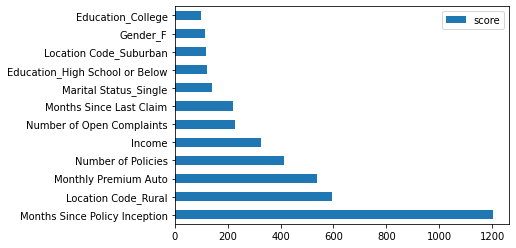

In [14]:
feature_important = bst.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

data.head(12).plot(kind='barh')

# Shapley values

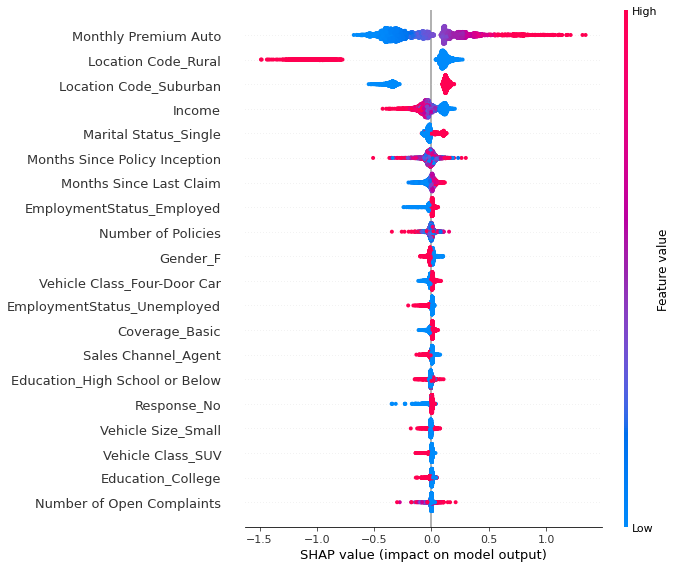

In [15]:
shap.initjs()

preds = bst.predict(dval)
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dval)
# "explain" one point
shap.force_plot(explainer.expected_value, shap_values[0,:], X_val.iloc[0,:])
shap.summary_plot(shap_values, X_val)

In [16]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# specify parameters via map
param = { 'eta':0.01, \
         'objective':'reg:gamma', \
         'eval_metric': 'mae',
         'base_score' : df["Total Claim Amount"].median(),
         'booster': 'gblinear', \
         # Enforce increasing/decreasing
         #'monotone_constraints': (-1,1,1),#tuple([1 for c in X_train.columns])
         'lambda': 0.01
        }
num_round = 2000
lin = xgb.train(param, dtrain, num_round)


In [45]:
# linreg
preds = lin.predict(dval)
mean_absolute_error(preds, y_val)

84.84529580605937

In [40]:
# make prediction
dtest = xgb.DMatrix(X_test, label=y_test)
preds = bst2.predict(dtest)
mean_absolute_error(preds, y_test)

62.50771793656029